In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

## 1A: Initializing the state space

In [5]:
class State:
    
    def __init__(self, x_position, y_position, heading):
        self.x_position = x_position
        self.y_position = y_position
        self.heading = heading
        
    def return_current_state(self):
        return self.x_position, self.y_position, self.heading

## 1B: Initializing the action space

In [6]:
class Action:
    
    def __init__(self, move, rotation):
        self.move = move
        self.rotation = rotation
        
    def return_action(self):
        return self.move, self.rotation

## 1C: Return the probabilty Psa(s') given pe, s, a, s'
## 1D: return a next state s' given error probability pe, s, a

### This is the Markov decision process

In [7]:
class MarkovDecisionProcess:
    
    # get the length and the width of the space that we are in
    def __init__(self, length, width):
        self.length = length
        self.width = width
    
    # check for bound violations
    def check_bounds(self, next_x, next_y, current_x, current_y):
        if (next_x < 0 or next_x >= self.width):
            next_x = current_x
        if (next_y < 0 or next_y >= self.length):
            next_y = current_y
        return next_x, next_y
    
    #define the directions
    left = {8,9,10}
    right = {2,3,4}
    up = {11,0,1}
    down = {5,6,7}
    
    # find out the next step --> returns next_x, next_y, next_heading
    def next_state_compiled(self, state, action):
        # get x, y and heading from state
        current_x = state.x_position
        current_y = state.y_position
        current_heading = state.heading
        
        # get move and rotation from action
        move = action.move
        rotation = action.rotation
        
        # check if heading is left, need to only change x and not y
        if current_heading in self.left:
            next_x = current_x - move
            next_y = current_y
        
        # check if heading is right, need to only change x and not y
        elif current_heading in self.right:
            next_x = current_x + move
            next_y = current_y
        
        # check if heading is up, need to only change y and not x
        elif current_heading in self.up:
            next_x = current_x
            next_y = current_y + move
        
        # check if heading is down, need to only change y and not x
        else:
            next_x = current_x
            next_y = current_y - move
        
        # need to check the bounds
        next_x, next_y = self.check_bounds(next_x, next_y, current_x, current_y)
        
        # finally, need to accomodate for the rotation in heading
        next_heading = (current_heading + rotation) % 12
        
        return next_x, next_y, next_heading
    
    # find out the next step for the movements that have the prob of error
    def next_state_individualized(self, current_x, current_y, current_heading, move, rotation):
        # check if heading is left, need to only change x and not y
        if current_heading in self.left:
            next_x = current_x - move
            next_y = current_y
        
        # check if heading is right, need to only change x and not y
        elif current_heading in self.right:
            next_x = current_x + move
            next_y = current_y
        
        # check if heading is up, need to only change y and not x
        elif current_heading in self.up:
            next_x = current_x
            next_y = current_y + move
        
        # check if heading is down, need to only change y and not x
        else:
            next_x = current_x
            next_y = current_y - move
        
        # need to check the bounds
        
        next_x, next_y = self.check_bounds(next_x, next_y, current_x, current_y)
        
        # finally, need to accomodate for the rotation in heading
        next_heading = (current_heading + rotation) % 12
        
        return next_x, next_y, next_heading
    
    # find out the transition probabilities
    def transition_probabilities(self, prob_of_error, action, current_state, next_state):
        # get move and rotation from action
        move = action.move
        rotation = action.rotation
        
        # if we do not move, current state should equal next state. 
        if move == 0:
            if current_state.return_current_state() == next_state.return_current_state():
                return 1
            else:
                return 0
        
        # in the case that we do move, need to account for the error probabilities
        
        if next_state.return_current_state() == self.next_state_compiled(current_state, action):
            return 1-(2*prob_of_error)
        else:
            current_x = current_state.x_position
            current_y = current_state.y_position
            current_heading = current_state.heading

            # need to check to return the prob of error
            if next_state.return_current_state() == self.next_state_individualized(current_x, current_y, (current_heading-1)%12, move, rotation):
                return prob_of_error

            if next_state.return_current_state() == self.next_state_individualized(current_x, current_y, (current_heading+1)%12, move, rotation):
                return prob_of_error
        
        return 0
    
    number_of_headings = 12
    
    # Part 1D
    def compute_next_state(self, prob_of_error, current_state, action):
        
        wrong_states = []
        # need to loop through all of the values of x, y and heading
        for i in range(self.length):
            for j in range(self.width):
                for k in range(self.number_of_headings):
                    # define the next state
                    next_state = State(i,j,k)
                    # find the transition probability between current state and the next state
                    prob_of_transition = self.transition_probabilities(prob_of_error, action, current_state, next_state)
                    # if the probability of transitioning does not equal 0, then only do we proceed. If 0, do not care
                    if prob_of_transition != 0:
                        # if our transition probabilty is the probability of error, it means that there was an error. Need to keep track of these next state values
                        if prob_of_transition == prob_of_error:
                            wrong_states.append(next_state)
                        else:
                            correct_next_state = next_state
        # if I choose a random number between 0 and 1 and my number is less than 2*prob_of_error, I move in the wrong direction. If not, I move in the correct direction.
        random_number_generated = np.random.uniform(0,1)
        if random_number_generated < 2*prob_of_error:
            random_index = random.randrange(len(wrong_states))
            return wrong_states[random_index]
        else:
            return correct_next_state
    def reward(self, current_state):
        # define the lengh and the width
        length = width = 6

        # get the current x, y positions -- do not care about heading
        current_x, current_y, _ = current_state.return_current_state()

        # define the rewards
        if current_x == 3 and current_y == 4:
            reward = 1
        elif current_x == 0 or current_x == width-1:
            reward = -100
        elif current_y == 0 or current_y == length-1:
            reward = -100
        elif current_x == 2 or current_x == 4:
            if current_y == 2 or current_y == 3 or current_y == 4:
                reward = -1
            else:
                reward = 0
        else:
            reward = 0
        return reward

## Test question 1

In [8]:
r = MarkovDecisionProcess(6,6)
s = State(1,1,0)
f = Action(1,0)

print(r.compute_next_state(0.1, s, f).return_current_state())

(1, 2, 1)


## Question 2: Write a function that returns the reward R(s) given input s.

In [9]:
def reward_func(self, current_state):
    # define the lengh and the width
    length = width = 6

    # get the current x, y positions -- do not care about heading
    current_x, current_y, _ = current_state.return_current_state()

    # define the rewards
    if current_x == 3 and current_y == 4:
        reward = 1
    if current_x == 0 or current_x == width-1:
        reward = -100
    if current_y == 0 or current_y == height-1:
        reward = -100
    if current_x == 2 or current_x == 4:
        if current_y == 2 or current_y == 3 or current_y == 4:
            reward = -1
    else:
        reward = 0
    return reward

## Question 3a: Create and populate a matrix/array that stores the action a = pi0(s) prescribed by the initial policy pi0 when indexed by state s.

In [10]:
class Policy_Matrix:
    def __init__(self, given_policy=None):
        if given_policy == None:
            up = {11, 0, 1}
            right = {2, 3, 4}
            down = {5, 6, 7}
            left = {8, 9, 10}

            mat_up    = [[None for x in range(6)] for y in range(6)]
            mat_down  = [[None for x in range(6)] for y in range(6)]
            mat_left  = [[None for x in range(6)] for y in range(6)]
            mat_right = [[None for x in range(6)] for y in range(6)]

            rot = 0 # rotation (none-0,left-1,right-2)
            mov = 0 # move (none-0,back-1,forward-2)

            # populate up matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if (x<3): # goal on right
                        rot = 2
                    elif (x>3): # goal on left
                        rot = 1
                    else:
                        rot = 0
                    # determine move
                    if (y<=4):
                        mov = 2
                    else:
                        mov = 1
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_up[x][y] = mov, rot

            # populate down matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if (x<3): # goal on left
                        rot = 1
                    elif (x>3): # goal on right
                        rot = 2
                    else:
                        rot = 0
                    # determine move
                    if (y<=3):
                        mov = 1
                    else:
                        mov = 2
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_down[x][y] = mov, rot

            # populate right matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if(y>4): # goal on right
                        rot = 2
                    elif(y<4): # goal on left
                        rot = 1
                    else:
                        rot = 0
                    # determine move
                    if(x<4):
                        mov = 2
                    else:
                        mov = 1
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_right[x][y] = mov, rot

            # populate left matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if(y>4): # goal on left
                        rot = 1
                    elif(y<4): # goal on right
                        rot = 2
                    else:
                        rot = 0
                    # determine move
                    if(x<3):
                        mov = 1
                    else:
                        mov = 2
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_left[x][y] = mov, rot

            # matrix for each heading degree
            self.pol_mat = [[]]*12
            for heading in range(12):
                if heading in up:
                    self.pol_mat[heading] = mat_up
                elif heading in down:
                    self.pol_mat[heading] = mat_down
                elif heading in left:
                    self.pol_mat[heading] = mat_left
                else:
                    self.pol_mat[heading] = mat_right
        else:
            self.pol_mat = given_policy
            
    def policy_action(self, current_state):        
        pos_x = current_state.x_position
        pos_y = current_state.y_position
        heading = current_state.heading
        return self.pol_mat[heading][pos_x][pos_y]

if __name__ == "__main__":
    pi_0 = Policy_Matrix()
#     print(pi_0.pol_mat)

## Question 3b: Write a function to generate and plot a trajectory of a robot given policy matrix/array , initial state s0, and error probability pe.

In [11]:
def compute_trajectory(policy, current_state, prob_of_error):
    # initialize the trajectory
    full_trajectory = []
    # get the current x and y position
    current_x, current_y, _ = current_state.return_current_state()
    # append the current x and y to the trajectory as an array
    full_trajectory.append([current_x, current_y])
    
    # keep looping till we get to the goal
    while current_x != 3 or current_y != 4:
        move_from_policy, rotation_from_policy = Policy_Matrix().policy_action(current_state)
        if move_from_policy == 0:
            move = 0
        if move_from_policy == 1:
            move = -1
        if move_from_policy == 2:
            move = 1
        if rotation_from_policy == 0:
            rotation = 0
        if rotation_from_policy == 1:
            rotation = -1
        if rotation_from_policy == 2:
            rotation = 1
        action = Action(move, rotation)
        next_state = MarkovDecisionProcess(6,6).compute_next_state(prob_of_error, current_state, action)
        current_x, current_y, _ = next_state.return_current_state()
        full_trajectory.append([current_x, current_y])
        current_state = next_state
        
    return full_trajectory

## Question 3c:

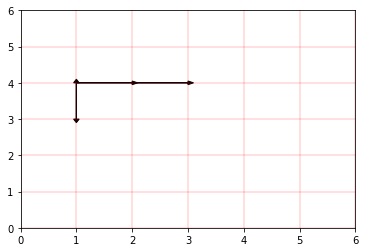

In [12]:
pi_0 = Policy_Matrix()
current_state = State(1,4,6)
full_trajectory = compute_trajectory(pi_0, current_state, 0)
plt.xlim(0,6)
plt.ylim(0,6)
for i in range(len(full_trajectory)-1):
#     pass
    x,y = full_trajectory[i]
    x_one_up, y_one_up = full_trajectory[i+1]
    plt.arrow(x,y,x_one_up-x,y_one_up-y, head_width=0.1, head_length=0.1,fc='k', ec='k')
# plt.arrow(1, 4, 0, -1, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.grid(color='r', linestyle='-', linewidth=0.25)
plt.show()

## Question 3d:

In [13]:
# Helped function to calcluate all adjacent states. Need this for both policy and value iteration
def calc_adj_states(current_state):
    x = current_state.x_position
    y = current_state.y_position
    h = current_state.heading
    
    next_poss_h = [h,  (h+1) % 12, (h-1) % 12, (h+2) % 12, (h-2) % 12] # five possible headings
    next_poss_x = [x] # first possibility is not moving
    next_poss_y = [y] # first possibility is not moving
    
    # down, up, left, right
    if (x-1 >= 0):
        next_poss_x.append(x-1)
    if (x+1 < 6):
        next_poss_x.append(x+1)
    if (y-1 >= 0):
        next_poss_y.append(y-1)
    if (y+1 < 6):
        next_poss_y.append(y+1)        
    
    all_adj_states = []
    for x1 in next_poss_x:
        for y1 in next_poss_y:
            for h1 in next_poss_h:
                all_adj_states.append(State(x1,y1,h1))
    return all_adj_states

def policy_evaluation(initial_poicy, discount_factor):
    #start by defining some constants
    prob_of_error = 0
    difference_between_iterations = -1
    
    init_V = np.zeros((6, 6, 12)) # initial value matrix
    
    # need to keep looping till we get to no difference between iterations
    while difference_between_iterations != 0:
        
        current_iteration = np.zeros((6, 6, 12))
        # need to loop through all possibilities
        for x_pos in range(6):
            for y_pos in range(6):
                for heading in range(12):
                    current_state = State(x_pos, y_pos, heading)
                    poss_states = calc_adj_states(current_state)
                    
                    for next_possible_state in poss_states:
                        # need to get the action, probability and reward
                        move_from_policy, rotation_from_policy = Policy_Matrix().policy_action(current_state)
                        if move_from_policy == 0:
                            move = 0
                        if move_from_policy == 1:
                            move = -1
                        if move_from_policy == 2:
                            move = 1
                        if rotation_from_policy == 0:
                            rotation = 0
                        if rotation_from_policy == 1:
                            rotation = -1
                        if rotation_from_policy == 2:
                            rotation = 1
                        action = Action(move, rotation)
                        probability_of_move = MarkovDecisionProcess(6,6).transition_probabilities(prob_of_error, action, current_state, next_possible_state)
                        current_x, current_y, _ = current_state.return_current_state()
#                         print(current_x, current_y)
                        reward_for_move = MarkovDecisionProcess(6,6).reward(current_state)
                        
                        next_possible_x, next_possible_y, next_possible_heading = next_possible_state.return_current_state()
                        current_iteration[x_pos, y_pos, heading] += probability_of_move * (reward_for_move+(discount_factor*init_V[next_possible_x, next_possible_y, next_possible_heading]))
                        
        difference_between_iterations = np.sum(np.abs(current_iteration - init_V))
        init_V = current_iteration
    
    return current_iteration

## Question 3e: What is the value of the trajectory in 3(c)? Use lambda = 0:9.

In [15]:
pi_0 = Policy_Matrix()
value = policy_evaluation(pi_0, 0.9)
print(value)

[[[-267.338962   -186.463621   -185.873131   -266.217031   -339.117031
   -185.217031   -266.873131   -339.707521   -339.117031   -267.463621
   -186.338962   -339.648472  ]
  [-266.27608    -185.93218     -96.07069     -95.41459     -94.68559
   -185.41459    -266.34169    -339.17608     -94.68559     -96.66118
    -95.27608    -339.17608   ]
  [-265.7512     -184.7512      -95.4802      -95.6341      -94.9051
   -184.8241     -265.7512     -339.707521    -94.9051     -301.39040611
   -323.66125018 -516.920131  ]
  [-463.24459    -184.168       -94.168       -94.978       -94.249
   -184.168      -266.34169    -339.17608     -94.249      -162.42508
   -168.17608    -339.17608   ]
  [-265.7512     -403.6051      -93.52        -93.52        -93.52
   -184.8241     -265.7512     -339.707521    -93.52        -93.52        -93.52
   -516.920131  ]
  [-463.24459    -184.168      -337.339      -265.168      -184.168
   -184.168      -266.34169    -339.17608    -185.27608    -267.66118
   -33

In [16]:
value[1][4][6]

5.8319999999999963

## Question 3f: Write a function that returns a matrix/array A giving the optimal policy given a one-step lookahead on value

In [17]:
def look_ahead(value):
    action_space = [(-1, -1), (-1, 0), (-1, 1), (0, 0), (1, -1), (1, 0), (1, 1)]
    init_policy = [[[0 for x in range(6)]for y in range(6)]for heading in range(12)]
    prob_of_error = 0
    # same setup as the last quesiton, iterating through current state and finding next possible states
    for x_pos in range(6):
            for y_pos in range(6):
                for heading in range(12):
                    current_state = State(x_pos, y_pos, heading)
                    poss_states = calc_adj_states(current_state)
                    best_action = None
                    max_action_val = float('-inf')
                    for act in action_space:
                        action = Action(act[0], act[1]) # create action object for transition probability calculation
                        action_val = 0
                        for next_state in poss_states:
                            x_next, y_next, heading_next = next_state.return_current_state()
                            mdp = MarkovDecisionProcess(6,6)
                            action_val += mdp.transition_probabilities(prob_of_error, action, current_state, next_state) * value[x_next][y_next][heading_next]
                        if (action_val > max_action_val):
                            max_action_val = action_val
                            best_action = action
                    init_policy[heading][y][x] = best_action
    finalized_policy = Policy_Matrix(given_policy=init_policy)
    return finalized_policy

In [18]:
finalized_policy = look_ahead(value)

## 3g: Combine 3f and 3d to returning optimal policy with optimal value V.

In [25]:
def policy_iteration(starting_policy, discount_factor):
        prev_value = policy_evaluation(starting_policy, discount_factor)
        prev_policy_maximized = look_ahead(prev_value)
        conv = 0
        
        while conv != 1:
            current_value = policy_evaluation(prev_policy_maximized, discount_factor)
            current_policy_maximized = look_ahead(current_value)
            if np.array_equal(current_value, prev_value):
                conv = 1
            
            prev_value = current_value
            prev_policy_maximized = current_policy_maximized
        return current_value, current_policy_maximized

## 3h:recompute and plot the trajectory and value of the robot described in 3(c) under the optimal policy

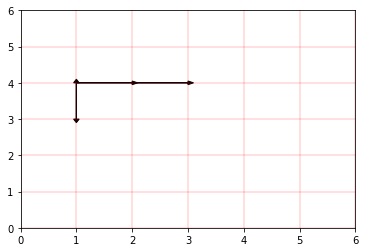

In [26]:
pi_0 = Policy_Matrix()
current_state = State(1,4,6)
discount_factor = 0.9
maxed_value, maxed_policy = policy_iteration(pi_0, discount_factor)
full_trajectory = compute_trajectory(maxed_policy, current_state, 0)
plt.xlim(0,6)
plt.ylim(0,6)
for i in range(len(full_trajectory)-1):
#     pass
    x,y = full_trajectory[i]
    x_one_up, y_one_up = full_trajectory[i+1]
    plt.arrow(x,y,x_one_up-x,y_one_up-y, head_width=0.1, head_length=0.1,fc='k', ec='k')
# plt.arrow(1, 4, 0, -1, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.grid(color='r', linestyle='-', linewidth=0.25)
plt.show()

## Question 4a:

In [80]:
action_space = [(-1, -1), (-1, 0), (-1, 1), (0, 0), (1, -1), (1, 0), (1, 1)]

def value_iteration(discount):
    prev_V = np.zeros((12, 6, 6)) # initial value matrix
    new_pol_mat = [[[None for l in range(6)] for w in range(6)] for h in range(12)] # new policy matrix
    err_p = 0 # error probability
    conv = 0 # convergence boolean
    
    while (conv != 1):
        new_V = np.zeros((12, 6, 6)) # new value matrix
        for x_pos in range(6):
            for y_pos in range(6):
                for heading in range(12):
                    current_state = State(x_pos, y_pos, heading)
                    poss_states = calc_adj_states(current_state)
                    best_action = None
                    max_action_val = float('-inf')
                    for act in action_space:
                        action = Action(act[0], act[1]) # create action object for transition probability calculation
                        action_val = 0
                        for next_state in poss_states:
                            x_, y_, h_ = next_state.return_current_state()
                            mdp = MarkovDecisionProcess(6,6)
                            
                            action_val += mdp.transition_probabilities(err_p, action, current_state, next_state) * (mdp.reward(current_state) + discount*prev_V[h_][x_][y_])
                        if (action_val > max_action_val):
                            max_action_val = action_val
                            best_action = action
                    # update policy matrix and new value matrix
                    new_pol_mat[heading][x_pos][y_pos] = best_action
                    new_V[heading][x_pos][y_pos] = max_action_val
        
        # check if convergence occurs
        if(np.array_equal(new_V, prev_V)):
            break
        # if not, update value matrix
        prev_v = new_V
    # create final policy
    new_pol = Policy(new_pol_mat)
    return new_pol

In [ ]:
# testing value iteration function
discount = 0.9
opt_pol = value_iteration(discount)


0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 

6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1


4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10

6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1


6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4


6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1


5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
1

6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1


8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5


9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2


10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5


0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 

2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 

1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 

0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 

0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 

1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 

1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 

1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 

2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 

5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
1

5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
1

7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0


8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3


11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5

10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3


10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0


8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3


10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0


8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3


10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0


0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 

11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5

0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 

2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 

3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 

4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10

4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10

5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
1

3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 

4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10

5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
1

5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
1

7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4


9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1


8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4


9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1


1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 

1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 

1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 

1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 

10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4


11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5

0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 

0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 

3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 

4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10

4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10

5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
1

10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5


10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2


9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5


7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2


8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5


8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2


9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5


9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2


10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5


11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5

2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 

2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 

6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5


5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
1

5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
1

3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 

2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 

2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 

5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
1

4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10

9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0


8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3


9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0


11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5

2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 

3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 

2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 

0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 

10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4


11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5

8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4


8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1


9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4


0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 

1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 

3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 

3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 

2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 

7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5


8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2


8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5


6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1


4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10

6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1


8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5


8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2


8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5


10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2


0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 

2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 

6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5


4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10

5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
1

3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 

3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 

2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 

4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10

3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 

5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
1

7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3


7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0


8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3


1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 

0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 

11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5

10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3


11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5

10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3


0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 

1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 

2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 

3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 

6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0


7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4


8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1


7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
4 3 4
5 3 4
6 3 4
7 3 4
8 3 4
9 3 4
10 3 4
11 3 4
0 3 5
1 3 5
2 3 5
3 3 5
4 3 5
5 3 5
6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4


6 3 5
7 3 5
8 3 5
9 3 5
10 3 5
11 3 5
0 4 0
1 4 0
2 4 0
3 4 0
4 4 0
5 4 0
6 4 0
7 4 0
8 4 0
9 4 0
10 4 0
11 4 0
0 4 1
1 4 1
2 4 1
3 4 1
4 4 1
5 4 1
6 4 1
7 4 1
8 4 1
9 4 1
10 4 1
11 4 1
0 4 2
1 4 2
2 4 2
3 4 2
4 4 2
5 4 2
6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0


6 4 2
7 4 2
8 4 2
9 4 2
10 4 2
11 4 2
0 4 3
1 4 3
2 4 3
3 4 3
4 4 3
5 4 3
6 4 3
7 4 3
8 4 3
9 4 3
10 4 3
11 4 3
0 4 4
1 4 4
2 4 4
3 4 4
4 4 4
5 4 4
6 4 4
7 4 4
8 4 4
9 4 4
10 4 4
11 4 4
0 4 5
1 4 5
2 4 5
3 4 5
4 4 5
5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3


5 4 5
6 4 5
7 4 5
8 4 5
9 4 5
10 4 5
11 4 5
0 5 0
1 5 0
2 5 0
3 5 0
4 5 0
5 5 0
6 5 0
7 5 0
8 5 0
9 5 0
10 5 0
11 5 0
0 5 1
1 5 1
2 5 1
3 5 1
4 5 1
5 5 1
6 5 1
7 5 1
8 5 1
9 5 1
10 5 1
11 5 1
0 5 2
1 5 2
2 5 2
3 5 2
4 5 2
5 5 2
6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
1

6 5 2
7 5 2
8 5 2
9 5 2
10 5 2
11 5 2
0 5 3
1 5 3
2 5 3
3 5 3
4 5 3
5 5 3
6 5 3
7 5 3
8 5 3
9 5 3
10 5 3
11 5 3
0 5 4
1 5 4
2 5 4
3 5 4
4 5 4
5 5 4
6 5 4
7 5 4
8 5 4
9 5 4
10 5 4
11 5 4
0 5 5
1 5 5
2 5 5
3 5 5
4 5 5
5 5 5
6 5 5
7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3


7 5 5
8 5 5
9 5 5
10 5 5
11 5 5
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1


8 0 2
9 0 2
10 0 2
11 0 2
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
0 0 4
1 0 4
2 0 4
3 0 4
4 0 4
5 0 4
6 0 4
7 0 4
8 0 4
9 0 4
10 0 4
11 0 4
0 0 5
1 0 5
2 0 5
3 0 5
4 0 5
5 0 5
6 0 5
7 0 5
8 0 5
9 0 5
10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4


10 0 5
11 0 5
0 1 0
1 1 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0
10 1 0
11 1 0
0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 1 1
0 1 2
1 1 2
2 1 2
3 1 2
4 1 2
5 1 2
6 1 2
7 1 2
8 1 2
9 1 2
10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1


10 1 2
11 1 2
0 1 3
1 1 3
2 1 3
3 1 3
4 1 3
5 1 3
6 1 3
7 1 3
8 1 3
9 1 3
10 1 3
11 1 3
0 1 4
1 1 4
2 1 4
3 1 4
4 1 4
5 1 4
6 1 4
7 1 4
8 1 4
9 1 4
10 1 4
11 1 4
0 1 5
1 1 5
2 1 5
3 1 5
4 1 5
5 1 5
6 1 5
7 1 5
8 1 5
9 1 5
10 1 5
11 1 5
0 2 0
1 2 0
2 2 0
3 2 0
4 2 0
5 2 0
6 2 0
7 2 0
8 2 0
9 2 0
10 2 0
11 2 0
0 2 1
1 2 1
2 2 1
3 2 1
4 2 1
5 2 1
6 2 1
7 2 1
8 2 1
9 2 1
10 2 1
11 2 1
0 2 2
1 2 2
2 2 2
3 2 2
4 2 2
5 2 2
6 2 2
7 2 2
8 2 2
9 2 2
10 2 2
11 2 2
0 2 3
1 2 3
2 2 3
3 2 3
4 2 3
5 2 3
6 2 3
7 2 3
8 2 3
9 2 3
10 2 3
11 2 3
0 2 4
1 2 4
2 2 4
3 2 4
4 2 4
5 2 4
6 2 4
7 2 4
8 2 4
9 2 4
10 2 4
11 2 4
0 2 5
1 2 5
2 2 5
3 2 5
4 2 5
5 2 5
6 2 5
7 2 5
8 2 5
9 2 5
10 2 5
11 2 5
0 3 0
1 3 0
2 3 0
3 3 0
4 3 0
5 3 0
6 3 0
7 3 0
8 3 0
9 3 0
10 3 0
11 3 0
0 3 1
1 3 1
2 3 1
3 3 1
4 3 1
5 3 1
6 3 1
7 3 1
8 3 1
9 3 1
10 3 1
11 3 1
0 3 2
1 3 2
2 3 2
3 3 2
4 3 2
5 3 2
6 3 2
7 3 2
8 3 2
9 3 2
10 3 2
11 3 2
0 3 3
1 3 3
2 3 3
3 3 3
4 3 3
5 3 3
6 3 3
7 3 3
8 3 3
9 3 3
10 3 3
11 3 3
0 3 4
1 3 4
2 3 4
3 3 4
